In [1]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

Anotaciones:
Desde el lado de Estadistica querriamos ver que tan bueno se aproxima a una gaussiana. Desde ML que tan bien generaliza

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [3]:
N = -1

In [4]:
data = pd.read_csv('data/alturas-pesos-mils-train.csv')[:N]

In [5]:
test = pd.read_csv('data/alturas-pesos-mils-test.csv')

In [6]:
from BiVariateJoint import BiVariateJoint

In [7]:
data_hombres = data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres = data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values

# Grafico los datos

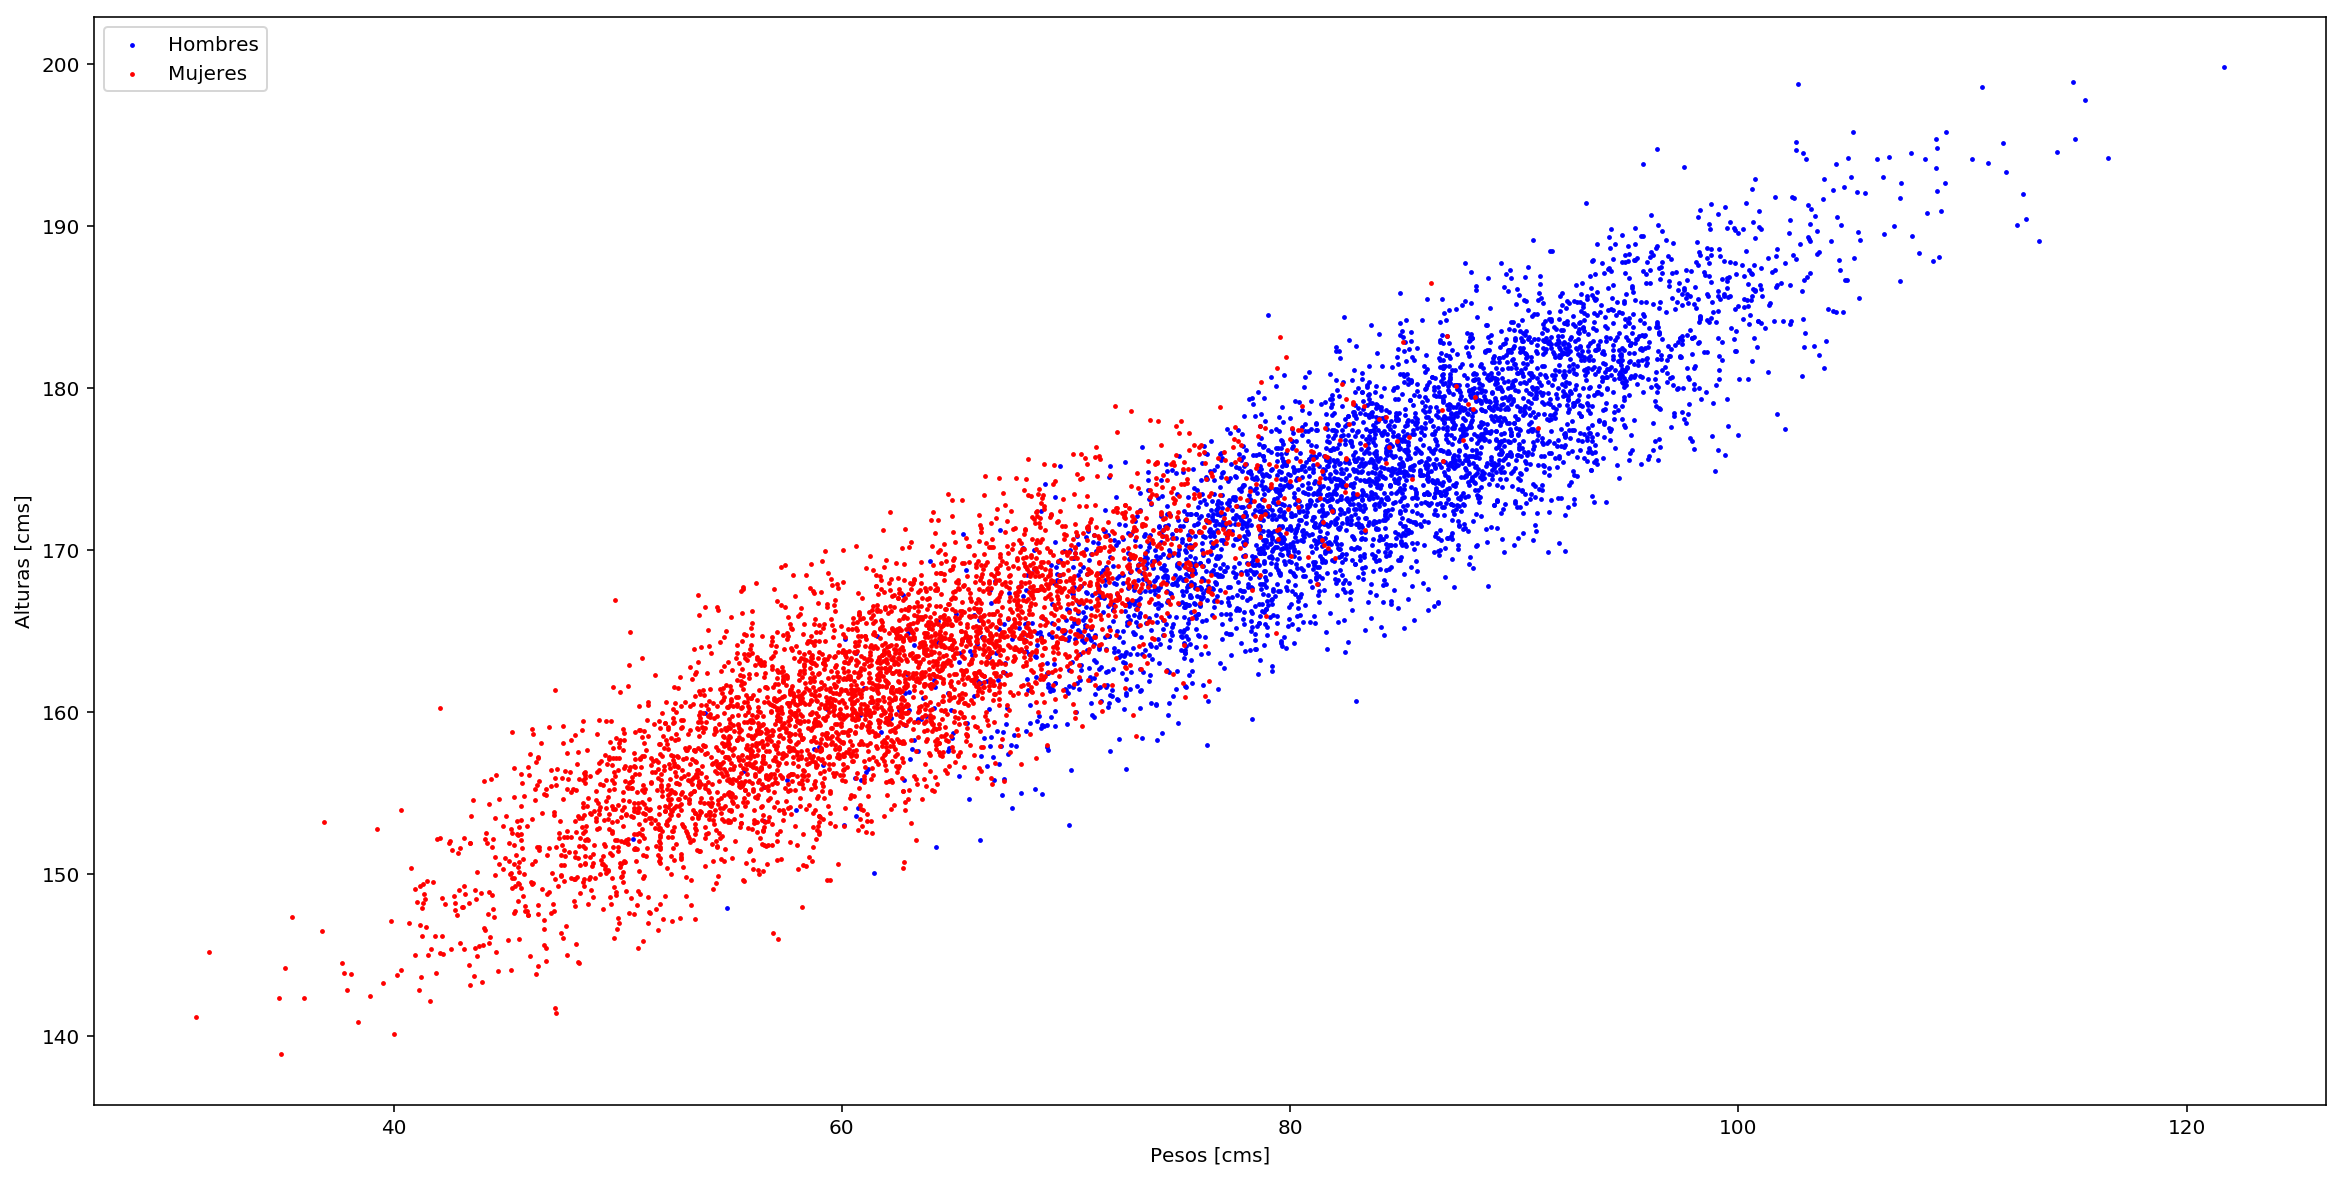

In [8]:
%matplotlib inline
f = plt.figure(figsize=(20,10))
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, label='Hombres')
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, label='Mujeres')
plt.xlabel('Pesos [cms]')
plt.ylabel('Alturas [cms]')
plt.legend()
plt.show()

# Regla de Bayes (Continuo)
\begin{equation}
P(Hombre | X_1, X_2) = \frac{p(X_1,X_2 | Hombre) P(Hombre)}{p(X_1,X_2)} \\ \\
\end{equation}

\begin{equation}
P(Mujer | X_1, X_2) = \frac{p(X_1,X_2 | Mujer) P(Mujer)}{p(X_1,X_2)}
\end{equation}

Que tenemos?
\begin{equation}
P(Hombre) = \frac{N_{H}}{N_H + N_M} \quad
\end{equation}

\begin{equation}
P(Mujer) = \frac{N_{M}}{N_H + N_M} \quad
\end{equation}


\begin{equation}
\large
p(X_1,X_2) = p(X_1,X_2 | Mujer) P(Mujer) + p(X_1,X_2 | Hombre) P(Hombre)
\end{equation}

Con estimar:
\begin{equation}
P(X_1,X_2 | Mujer) \quad y \quad
P(X_1,X_2 | Hombre) 
\end{equation}
\begin{equation}
o
\end{equation}
\begin{equation}
p(X_1,X_2 | Mujer) \quad y \quad
p(X_1,X_2 | Hombre) 
\end{equation}

# Bayes Gaussiano (Quadratic Discriminant Analisys)

\begin{equation}
P(Hombre | X_1, X_2) = \frac{p(X_1,X_2 | Hombre) P(Hombre)}{p(X_1,X_2)} \\
P(Mujer | X_1, X_2) = \frac{p(X_1,X_2 | Mujer) P(Mujer)}{p(X_1,X_2)} \\
p(X_1,X_2) = p(X_1,X_2 | Hombre) P(Hombre) + p(X_1,X_2 | Mujer) P(Mujer)
\end{equation}

\begin{equation}
P(C_0 | X_1, X_2)  \rightarrow p \\
P(C_1 | X_1, X_2) \rightarrow (1-p) \\
\end{equation}
### Log-odds
\begin{equation}
\frac{p}{1-p} = \frac{p(X_1,X_2 | C_0) P(C_0)}{
 p(X_1,X_2 | C_1) P(C_1)}
\end{equation}

In [9]:
peso_altura_hombres = data.loc[data['Genero']=='Hombre'][['Peso', 'Altura']].values
peso_altura_mujeres = data.loc[data['Genero']=='Mujer'][['Peso', 'Altura']].values

In [10]:
mean_hombres = peso_altura_hombres.mean(axis=0)
mean_mujeres = peso_altura_mujeres.mean(axis=0)

In [11]:
cov_hombres = np.cov(peso_altura_hombres.T)
cov_mujeres = np.cov(peso_altura_mujeres.T)

In [12]:
from scipy.stats import multivariate_normal

In [13]:
def get_gauss_prob(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_hombres, cov_hombres)
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_mujeres, cov_mujeres)
    N_class_1 = len(peso_altura_hombres)
    N_class_2 = len(peso_altura_mujeres)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    return p_class_1, p_class_2

In [14]:
def get_acc_gauss(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    p_class_1, p_class_2 = get_gauss_prob(data[['Peso', 'Altura']].values, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)
    return ((p_class_1>p_class_2)==(data['Genero']=='Hombre')).sum()/len(p_class_1)

In [15]:
acc_train_Bayes = get_acc_gauss(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)
print(acc_train_Bayes)

0.9167395924490561


In [16]:
acc_cv_Bayes = get_acc_gauss(test, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)
print(acc_cv_Bayes)

0.9225


In [17]:
N = 300
X = np.linspace(data.min()['Peso'], data.max()['Peso'], N)
Y = np.linspace(data.min()['Altura'], data.max()['Altura'], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z_H = multivariate_normal.pdf(pos, mean_hombres, cov_hombres)
Z_M = multivariate_normal.pdf(pos, mean_mujeres, cov_mujeres)
Z_gaus, _ = get_gauss_prob(pos, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)

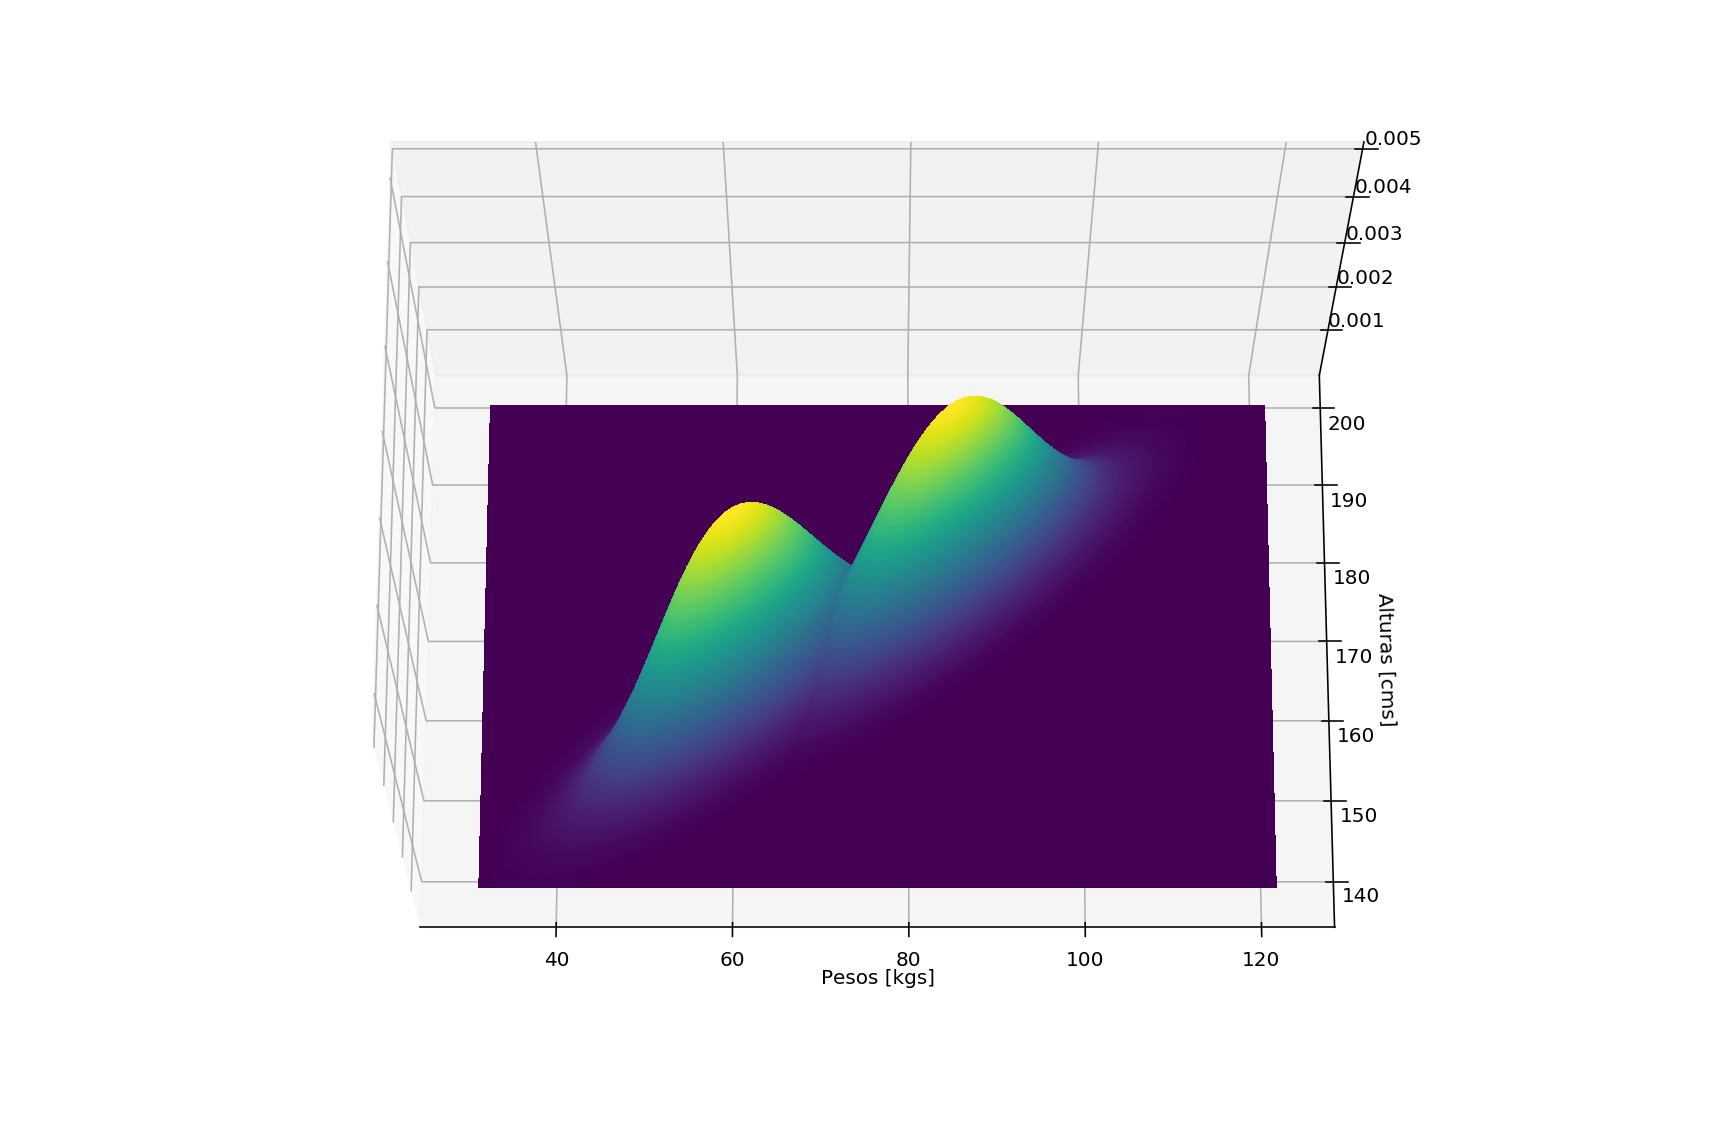

In [18]:
%matplotlib inline
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
cm = plt.cm.RdBu
ax.contourf(X, Y, Z_H, 256)
ax.contourf(X, Y, Z_M, 256)
ax.view_init(70, -90)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.show()

### Log odds
\begin{equation}
\frac{P(C_0 | X_1, X_2)}{P(C_1 | X_1, X_2)} = \frac{p(X_1,X_2 | C_0) P(C_0)}{p(X_1,X_2 | C_1) P(C_1)} \\
\end{equation}

\begin{equation}
odds = \frac{p(X_1,X_2 | C_0)}{p(X_1,X_2 | C_1)} \\
\end{equation}

Dado que las densidades son Gaussianas:

\begin{equation}
\large
\frac{\sqrt{|2\pi\Sigma_0|}^{-1} e^{-\frac{1}{2} (x-\mu_0)^T\Sigma_0(x-\mu_0) }P(C_0)}
{\sqrt{|2\pi\Sigma_1|}^{-1} e^{-\frac{1}{2} (x-\mu_1)^T\Sigma_1(x-\mu_1) } P(C_1)} = 1
\end{equation}

Aplicando logaritmos y agrupando todas las constantes en T:

\begin{equation}
\large
log{\frac{\sqrt{|2\pi\Sigma_0|}^{-1} e^{-\frac{1}{2} (\vec{x}-\vec{\mu}_0)^T\Sigma_0 \big (\vec{x}-\vec{\mu}_0) }P(C_0)}
{\sqrt{|2\pi\Sigma_1|}^{-1} e^{-\frac{1}{2} (\vec{x}-\vec{\mu}_1)^T\Sigma_1(\vec{x}-\vec{\mu}_1) } P(C_1)}} = 0
\end{equation}

\begin{equation}
\large
-\frac{1}{2}(\vec{x}-\vec{\mu}_0)^T\Sigma_0^{-1}(\vec{x}-\vec{\mu}_0) + \frac{1}{2}(\vec{x}-\vec{\mu}_1)^T\Sigma_1^{-1}(\vec{x}-\vec{\mu}_1)  - ln(|\Sigma_0|) + ln(|\Sigma_1|) + log(\frac{P(C_0)}{P(C_1)}) = 0
\end{equation}

Notar que es cuadratica

In [19]:
# Verificación ecuación
z_teorica = np.zeros([N, N])
log_cov_H = np.log(np.linalg.det(cov_hombres))
log_cov_M = np.log(np.linalg.det(cov_mujeres))
log_priors = np.log(len(peso_altura_hombres)/len(peso_altura_mujeres))
for row in range(pos.shape[0]):
    for col in range(pos.shape[1]):
        nomalized_x_H = pos[row, col] - mean_hombres
        nomalized_x_M = pos[row, col] - mean_mujeres
        term_1 = nomalized_x_H.dot(np.linalg.inv(cov_hombres)).dot(nomalized_x_H)/2
        term_2 = nomalized_x_M.dot(np.linalg.inv(cov_mujeres)).dot(nomalized_x_M)/2
        z_teorica[row, col] = - term_1 + term_2 - log_cov_H + log_cov_M + log_priors

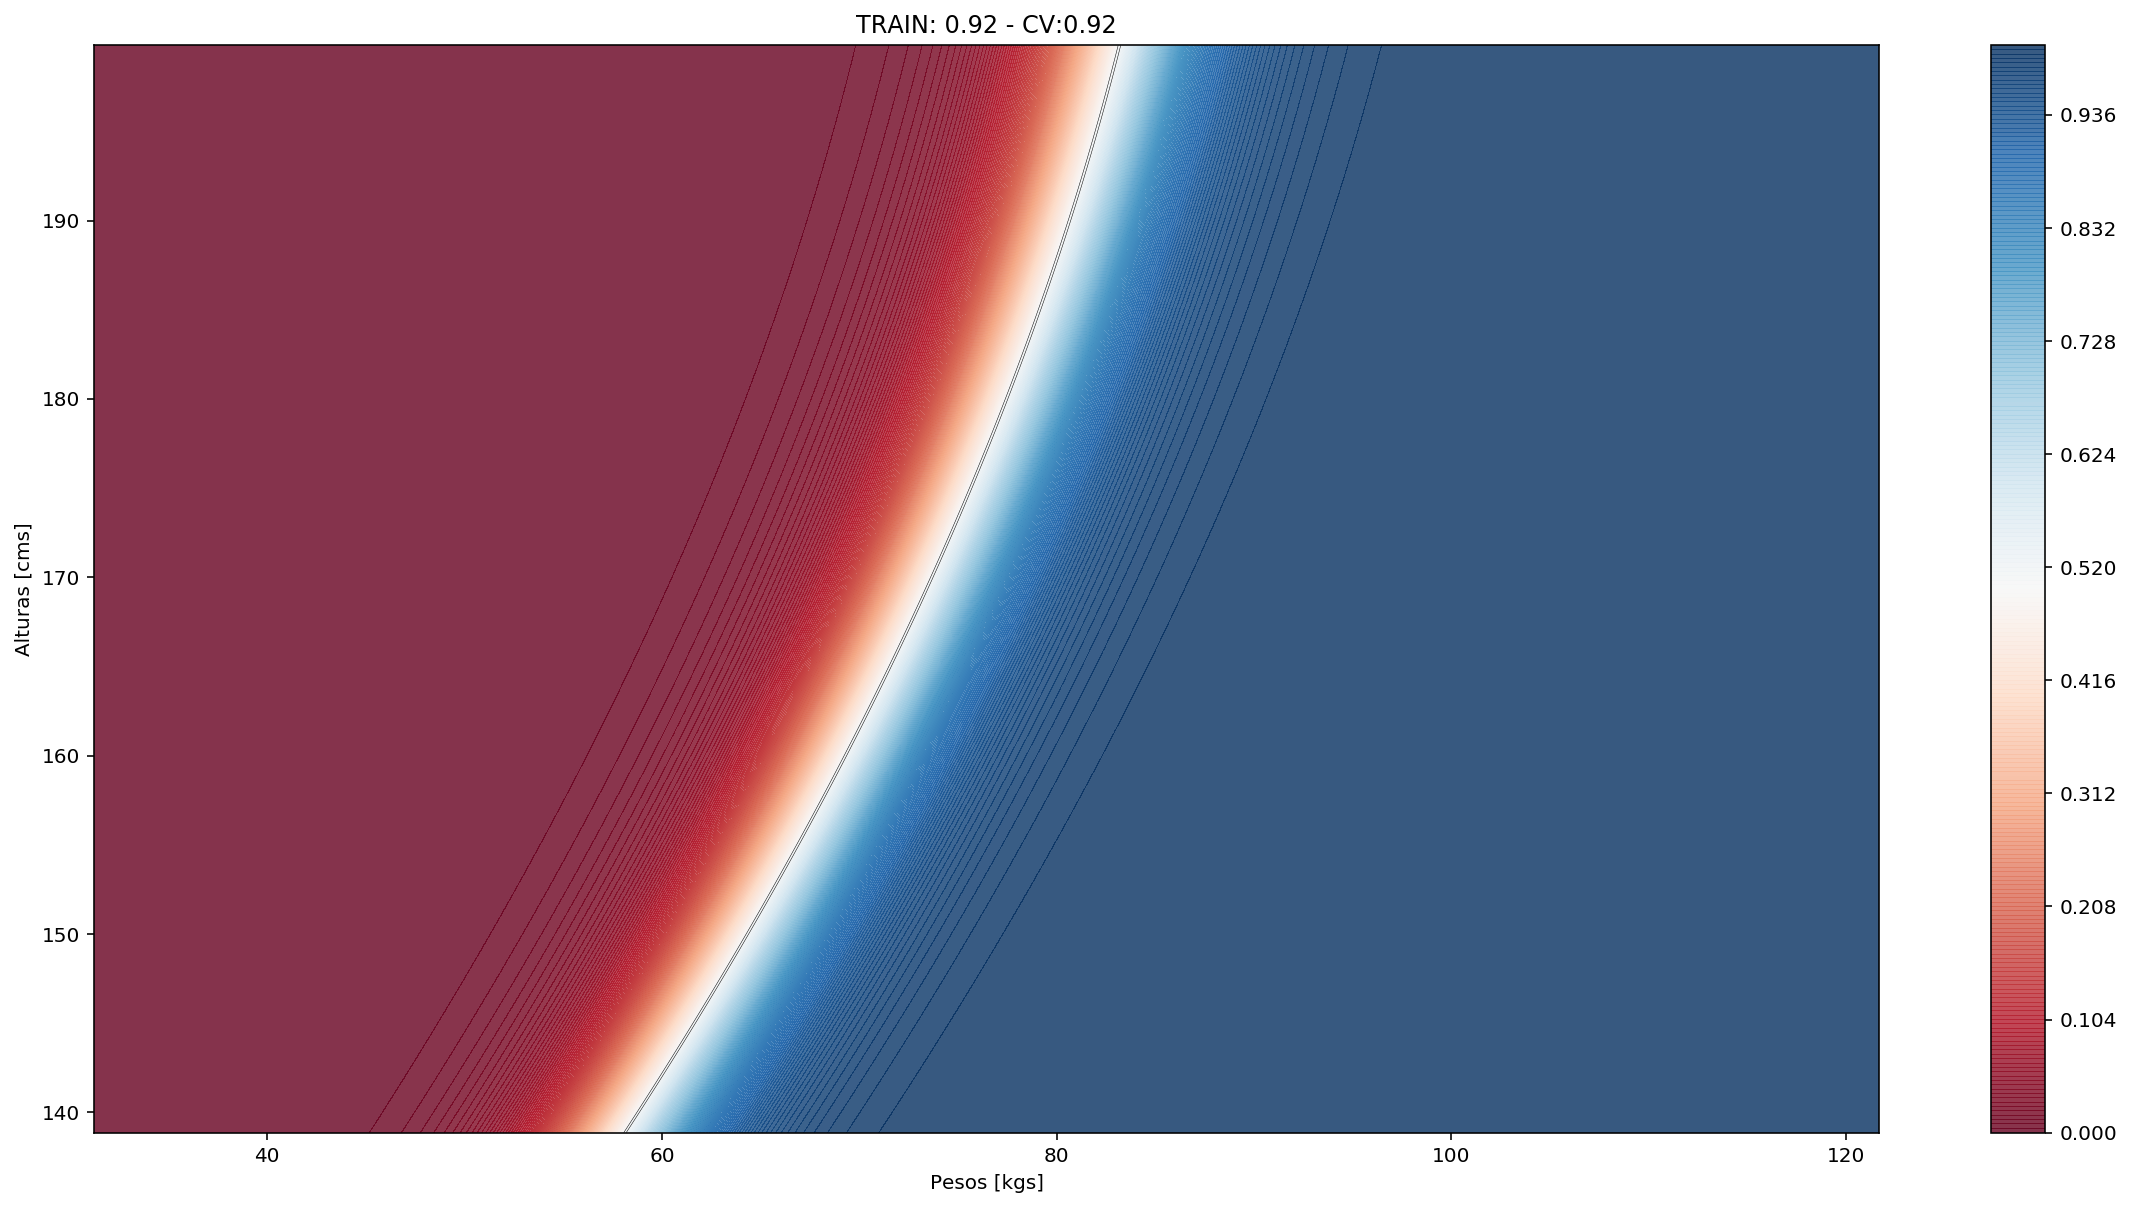

In [20]:
# Verificación
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_gaus, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
z_levels = np.logspace(-5,-2,10)/4
#ax.contour(X, Y, Z_H, z_levels)
#ax.contour(X, Y, Z_M, z_levels)
ax.contour(X, Y, Z_gaus, (0.5,), colors='k', linewidths=0.25)
ax.contour(X, Y, z_teorica, (0,), colors='k', linewidths=0.25)
ax.set_title('TRAIN: ' + str(np.round(acc_train_Bayes*100)/100) + ' - CV:' + str(np.round(acc_cv_Bayes*100)/100))
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.show()

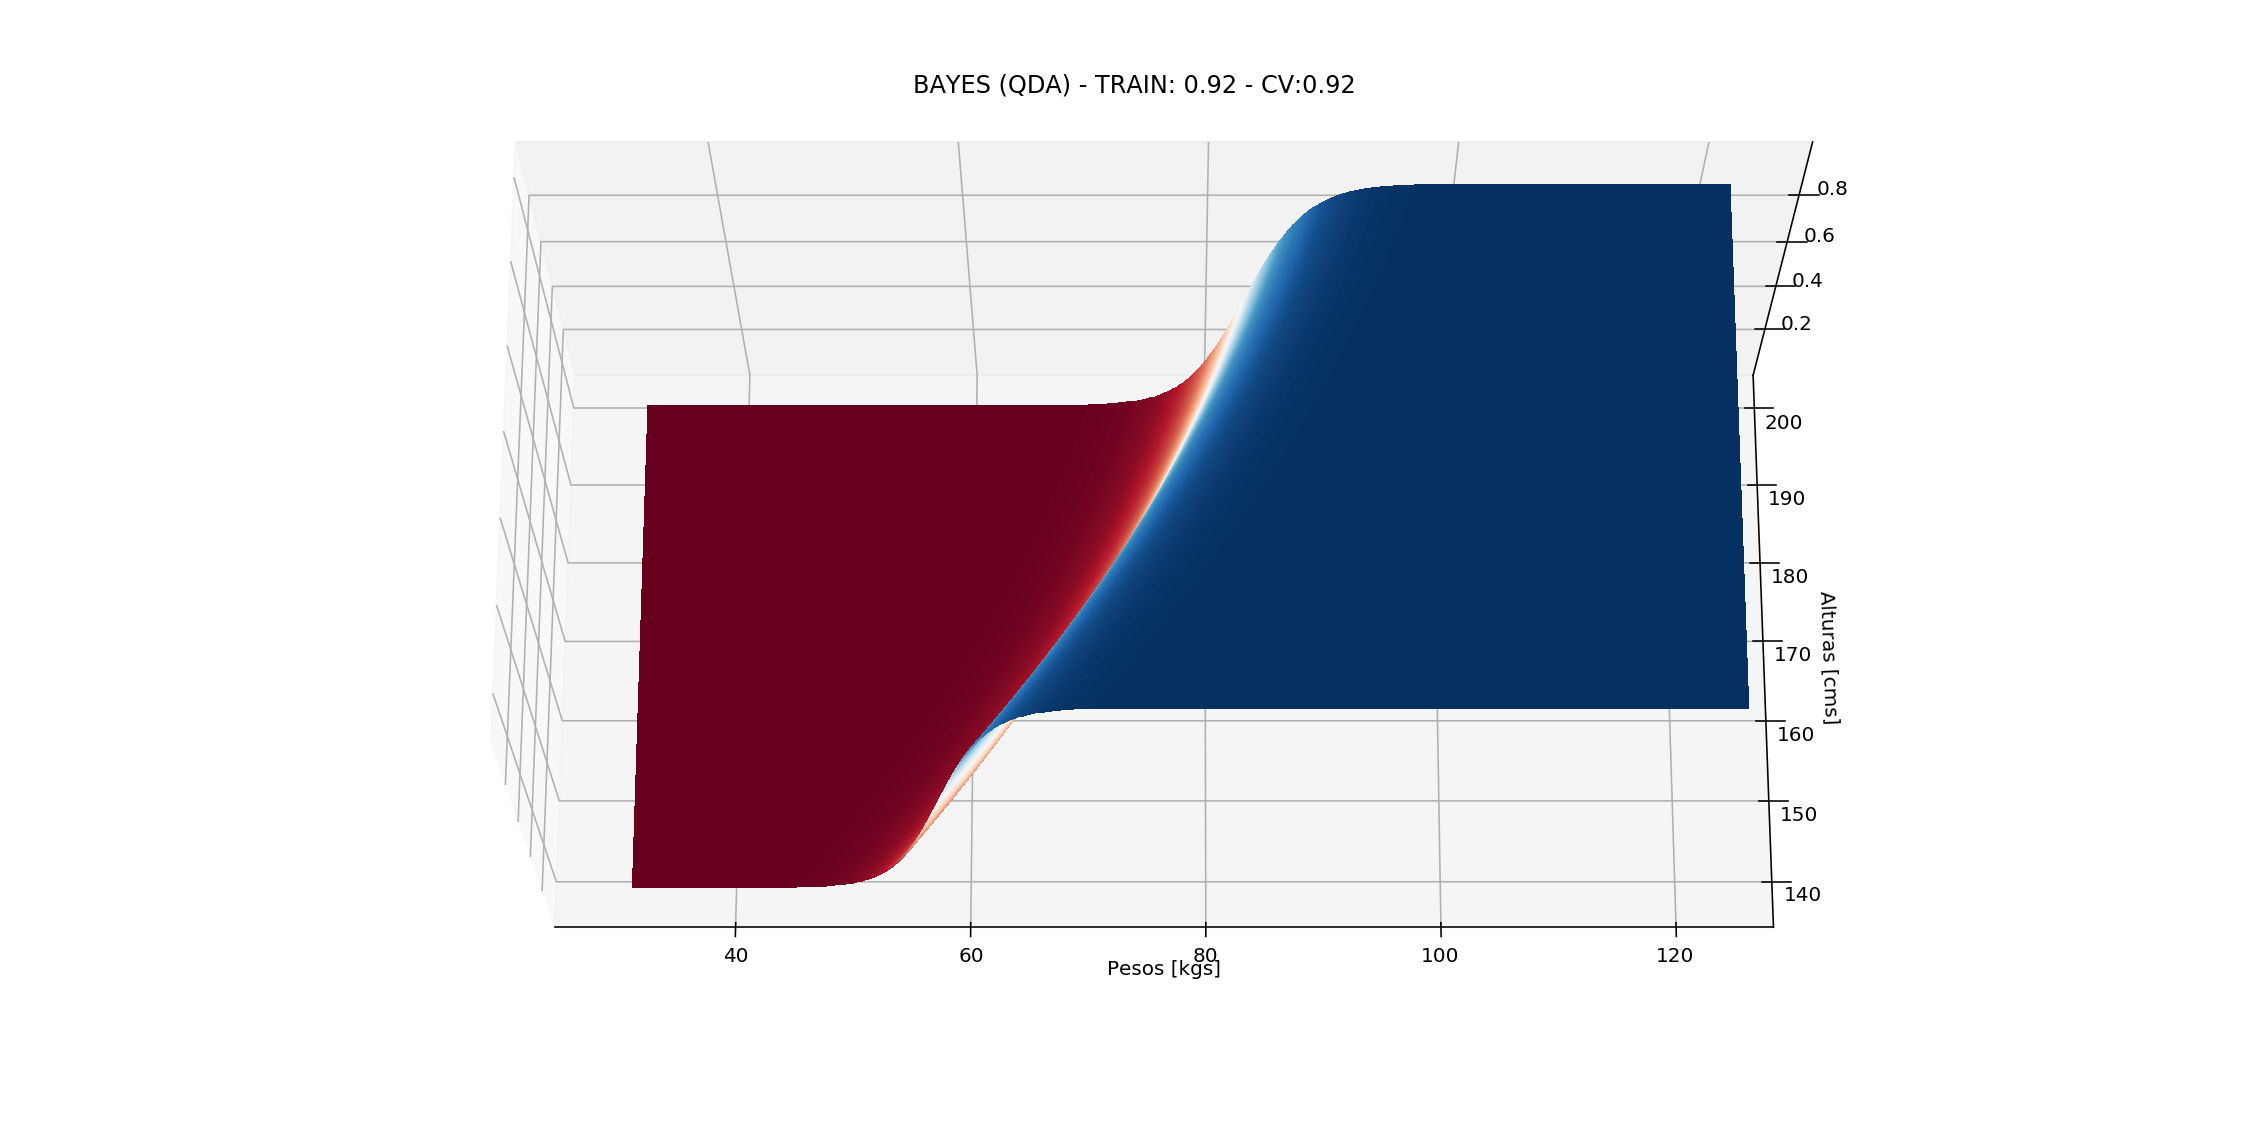

In [21]:
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
cm = plt.cm.RdBu
ax.contourf(X, Y, Z_gaus, 256, vmin=0., vmax=1., cmap=cm)
ax.set_title('BAYES (QDA) - TRAIN: ' + str(np.round(acc_train_Bayes*100)/100) + ' - CV:' + str(np.round(acc_cv_Bayes*100)/100))
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
ax.view_init(70, -90)
plt.show()

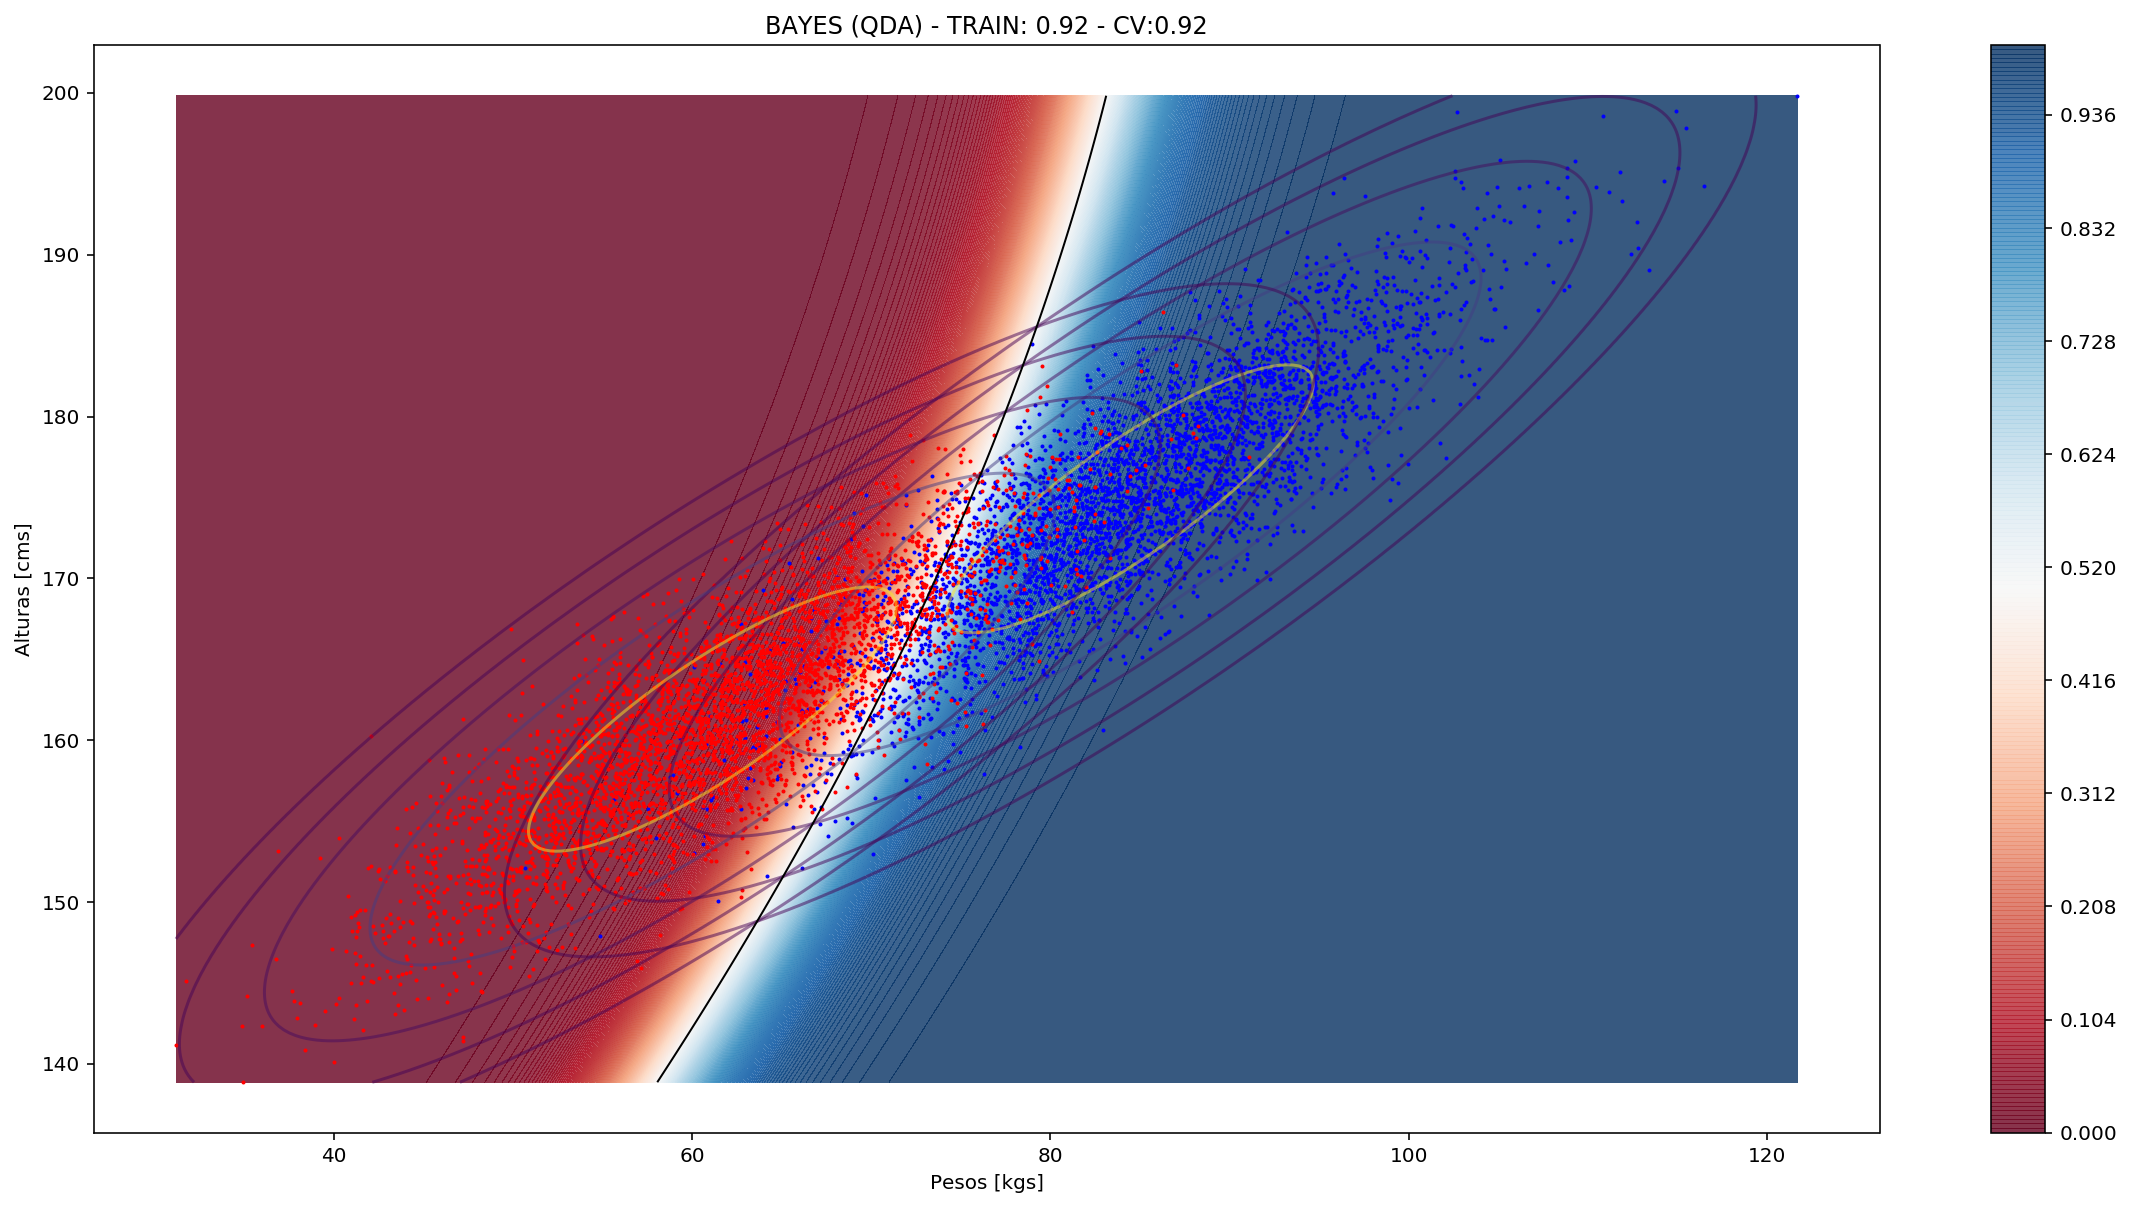

In [22]:
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_gaus, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
z_levels = np.logspace(-5,-2,5)/4
ax.contour(X, Y, Z_H, z_levels, alpha=0.5)
ax.contour(X, Y, Z_M, z_levels, alpha=0.5)
ax.contour(X, Y, Z_gaus, (0.5,), colors='k', linewidths=1)
ax.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=1, label='Hombres')
ax.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=1, label='Mujeres')
ax.set_title('BAYES (QDA) - TRAIN: ' + str(np.round(acc_train_Bayes*100)/100) + ' - CV:' + str(np.round(acc_cv_Bayes*100)/100))
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.show()

|Modelo| tipo| Train Acc| CV Acc|Comentarios
|-| -| -| -|-|
|Histogram - step 0.25|Bayes|0.97|0.68
|Histogram - step 0.25|Naive Bayes|0.89|0.88
|Histogram - step 0.5|Bayes|0.94|0.82
|Histogram - step 0.5|Naive Bayes|0.89|0.88
|Histogram - step 1|Bayes|0.92|0.90
|Histogram - step 1|Naive Bayes|0.89|0.88
|Histogram - step 4|Bayes|0.91|0.92| No generaliza por afuera de la zona de los puntos
|Histogram - step 4|Naive Bayes|0.89|0.88
|Histogram - step 8|Bayes|0.90|0.90
|Histogram - step 8|Naive Bayes|0.87|0.86
|Gaussian|Bayes|0.92|0.92|
|Gaussian|Naive Bayes|0.89|0.89|
|Regresion Logística|-|0.92|0.92|